# Decision Tree Models

Contents:
1. [Introduction](#Introduction)
2. [Classification](#Classification)
3. [Regression](#Regression)
4. [Hyperparameters](#Hyperparameters)
5. [Summary](#Summary)

## Introduction

Decision trees are built as a set of rules for both classification and regression problems.

These are the building blocks for more elaborate models such as random forest and gradient boosting trees.

A decision tree is a set of rules, combined in a hierarchical manner.

In the example of the `adult_census` dataset (trying to predict income class), if a new point has to be classified:

1. we will first check the age feature, if it is lower than 28.5, we shall classify it as "low income".

2. Otherwise, depending on the hours per week feature, we will classify it as low or high income.

On both sides of the __threshold__, each __leaf node__ stores the number of training points of each class that reached that node by following the decisions starting from the __root noode__.

On both sides of the threshold, we store in the __child node__ the number of training points that reached that node for each possible value of y.

Whenever we add a new __split node__, the selected feature and the optimal threshold are tuned by maximizing the improvement in a quantity named _entropy_ or _gini index_ that __measures how mixed are the classes in the nodes__. The goal is to __find splits such that both child nodes are as pure as possible__.

For test data points, we start again from the root of the tree and the same thresholds is used to decide which branch to follow at each split node until the test sample reaches a __leaf node__.

The tree predicts the __fraction of training points of each class that reached that node, divided by the total number of training points that reached that node__. Those values can be interpreted as __class assignment probabilities__.

We can incrementally expand any leaf to refine the decision function. At each step, the leaf focuses on a __smaller subregion__ of the space.

<img src="diagrams/Decision%20Tree%20diagram.jpg" width=600/>

Decision trees can also fit __regression__ problems.

Let's consider the following simple regression problem with a single feature as input on the x axis. The y axis represent the continuous value of the y variable.

Each black point represents a training data points.

Observe that it is not possible to use a straight line to approximate this dataset (see below). One could therefore expect simple linear regression models to underfit on this problem.

As for classification we choose one feature and a threshold value is selected for this feature to define the root of the tree (the first split node).

On both sides of the threshold, we store in the __child node__ the __average value of y__ for each training point that reached that node.

Whenever we add a new split node, the selected feature and the optimal threshold are tuned by maximizing the improvement in prediction error that would result by the introduction of the split.

For test data points, we start again from the root of the tree and the same thresholds is used to decide which branch to follow at each step until the test sample reaches a __leaf node__.

The tree __predicts the numerical value stored in the selected leaf node__.

As a result the decision tree prediction function is always __piece-wise constant__.

At each iteration, one considers which leaf node node can be further replaced by a split node to refine the prediction function, therefore replacing it by a new split node and 2 new leaf nodes.

The learning algorithms stops developing the trees either 
- when there is only one data points per leaf node 
- or when we have reached pre-defined tree size, expressed either as a maximum depth or maximum number of leaf nodes.

Decision Trees are non-parametric models: the __maximum size of the tree depends on the number of data points in the training set__: it is not possible to develop a very deep decision tree on a training set with just a few training point.

Choosing a maximum size can significantly impact the generalization performance of the model.

<table>
    <tr>
        <td> <img src="diagrams/Decision%20Tree%20Regression%20diagram.jpg" width=700/></td> 
        <td> <img src="diagrams/Decision%20Tree%20under-overfittingdiagram.jpg" width=700/></td>
    </tr>
</table>

<u>Key points</u>:
- Sequence of simple decision rules:

- one feature and one threshold at a time

- __No scaling required__ for numerical features

- max_depth controls the trade-off between underfitting and overfitting

- Mostly useful as a building block for ensemble models

    - Random Forests
    - Gradient Boosting Decision Trees

In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
sklearn.set_config(display="diagram")

## Classification

In [54]:
# load data
penguins = pd.read_csv("datasets/penguins_classification.csv")
# split feature and target columns
culmen_columns = ["Culmen Length (mm)", "Culmen Depth (mm)"]
target_column = "Species"

In [55]:
from sklearn.model_selection import train_test_split
# select data and target features
data, target = penguins[culmen_columns], penguins[target_column]
# split into test and train sets
data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=0)
# get feature ranges for plotting later
range_features = {
    feature_name: (penguins[feature_name].min() - 1,
                   penguins[feature_name].max() + 1)
    for feature_name in culmen_columns
}

In [56]:
from sklearn.linear_model import LogisticRegression

# examine boundaries for Logistic regression for comparison
linear_model = LogisticRegression()
#fit linear model
linear_model.fit(data_train, target_train)

LogisticRegression()

In [57]:
# create function to help with plotting
def plot_decision_function(fitted_classifier, range_features, ax=None):
    """Plot the boundary of the decision function of a classifier."""
    from sklearn.preprocessing import LabelEncoder

    feature_names = list(range_features.keys())
    # create a grid to evaluate all possible samples
    plot_step = 0.02
    xx, yy = np.meshgrid(
        np.arange(*range_features[feature_names[0]], plot_step),
        np.arange(*range_features[feature_names[1]], plot_step),
    )

    # compute the associated prediction
    Z = fitted_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = LabelEncoder().fit_transform(Z)
    Z = Z.reshape(xx.shape)

    # make the plot of the boundary and the data samples
    if ax is None:
        _, ax = plt.subplots()
    ax.contourf(xx, yy, Z, alpha=0.4, cmap="RdBu_r")

    return ax

C:\Users\GGN04\Anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


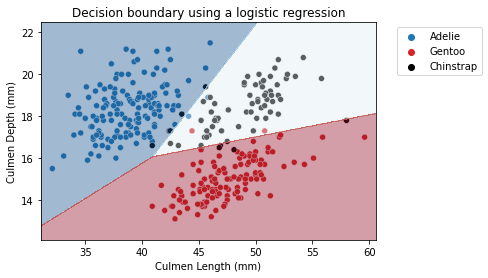

In [58]:
# create a palette to be used in the scatterplot
palette = [ "tab:blue","tab:red", "black"]
# plot the data
ax = sns.scatterplot(data=penguins, x=culmen_columns[0], y=culmen_columns[1],
                hue=target_column, palette=palette)
# uses the function above to display the computed class areas
_ = plot_decision_function(linear_model, range_features, ax=ax)

# put the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
_ = plt.title("Decision boundary using a logistic regression")

In [60]:
# call accuracy of fitted model
test_score = linear_model.score(data_test, target_test)
print(f"Accuracy of the LogisticRegression: {test_score:.2f}")

Accuracy of the LogisticRegression: 0.98


Unlike linear models, decision trees are non-parametric models: they are not controlled by a mathematical decision function and __do not have weights or intercept to be optimized__.

Indeed, decision trees will partition the space by considering a __single feature at a time__. Let’s illustrate this behaviour by having a decision tree make a single split to partition the feature space

In [61]:
from sklearn.tree import DecisionTreeClassifier
# create tree model with depth of 1
tree = DecisionTreeClassifier(max_depth=1)
# fit the model
tree.fit(data_train, target_train)

DecisionTreeClassifier(max_depth=1)

C:\Users\GGN04\Anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


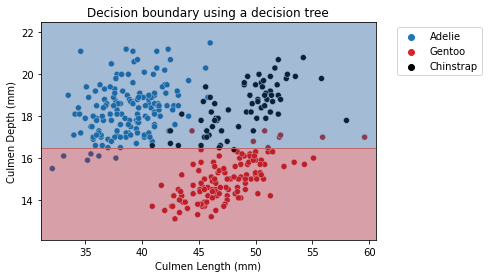

In [62]:
# plot data
ax = sns.scatterplot(data=penguins, x=culmen_columns[0], y=culmen_columns[1],
                hue=target_column, palette=palette)
# plot decision boundary
_ = plot_decision_function(tree, range_features, ax=ax)
# add labels
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
_ = plt.title("Decision boundary using a decision tree")

The partitions found by the algorithm separates the data along the axis “Culmen Depth”, discarding the feature “Culmen Length”. Thus, it highlights that a decision tree __does not use a combination of features__ when making a split. We can look more in depth at the tree structure.

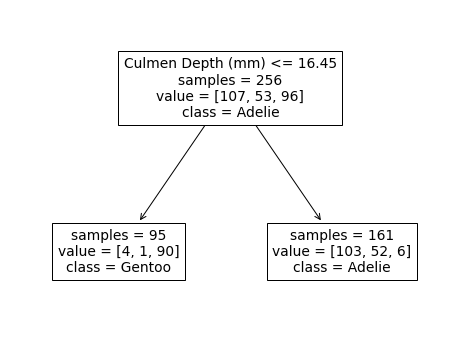

In [10]:
from sklearn.tree import plot_tree

_, ax = plt.subplots(figsize=(8, 6))
_ = plot_tree(tree, feature_names=culmen_columns,
              class_names=tree.classes_, impurity=False, ax=ax)

- First Box lists total, value bracket shows total for each species
- Second row shows that 95 __were__ <= 16.45, and the majority class with 90 is Gentoo
- Next box is for the 161 samples that __were not__ <= 16.45, with a majority of 103 Adelie

In [11]:
# predict for culmen depth below threshold
tree.predict([[0, 15]])

C:\Users\GGN04\Anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


array(['Gentoo'], dtype=object)

In [12]:
# predict for culmen depth above threshold
tree.predict([[0, 17]])

C:\Users\GGN04\Anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


array(['Adelie'], dtype=object)

__A decision tree classifier will predict the most represented class within a partition.__

During the training, we have a count of samples in each partition, we can also compute the probability of belonging to a specific class within this partition.

C:\Users\GGN04\Anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


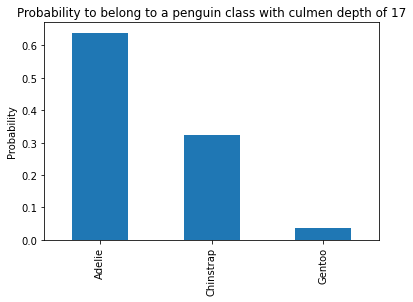

In [13]:
# get predictions for Culmen Depth = 17 (and Culmen Length = 0)
y_pred_proba = tree.predict_proba([[0, 17]])
# combine in Series
y_proba_class_0 = pd.Series(y_pred_proba[0], index=tree.classes_)
# plot results
y_proba_class_0.plot.bar()
plt.ylabel("Probability")
_ = plt.title("Probability to belong to a penguin class with culmen depth of 17")

In [14]:
# manually check the probabilities for culmen depth of 17
adelie_proba = 103 / 161
chinstrap_proba = 52 / 161
gentoo_proba = 6 / 161
print(f"Probabilities for the different classes:\n"
      f"Adelie: {adelie_proba:.3f}\n"
      f"Chinstrap: {chinstrap_proba:.3f}\n"
      f"Gentoo: {gentoo_proba:.3f}\n")

Probabilities for the different classes:
Adelie: 0.640
Chinstrap: 0.323
Gentoo: 0.037



In [15]:
# Note culmen length is being DISREGARDED for the moment
tree.predict_proba([[10000, 17]])

C:\Users\GGN04\Anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


array([[0.63975155, 0.32298137, 0.03726708]])

In [16]:
# evaluate accuracy (model is already fitted)
test_score = tree.score(data_test, target_test)
print(f"Accuracy of the DecisionTreeClassifier: {test_score:.2f}")

Accuracy of the DecisionTreeClassifier: 0.78


In [17]:
# now use a tree with a depth of 2
tree = DecisionTreeClassifier(max_depth=2)
tree.fit(data_train, target_train)

DecisionTreeClassifier(max_depth=2)

C:\Users\GGN04\Anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


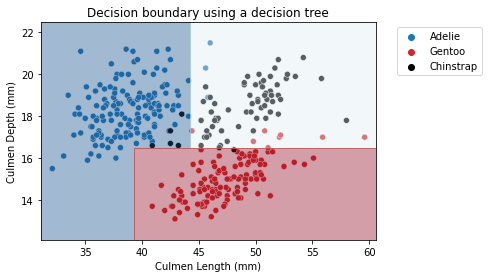

In [18]:
# plot data
ax = sns.scatterplot(data=penguins, x=culmen_columns[0], y=culmen_columns[1],
                     hue=target_column, palette=palette)
# plot boundary
_ = plot_decision_function(tree, range_features, ax=ax)
# add labels
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
_ = plt.title("Decision boundary using a decision tree")

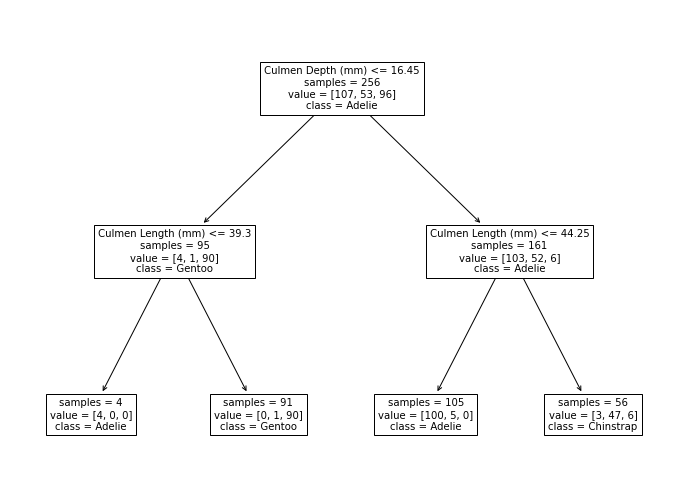

In [19]:
_, ax = plt.subplots(figsize=(12, 9))
_ = plot_tree(tree, feature_names=culmen_columns,
              class_names=tree.classes_, impurity=False, ax=ax)

The resulting tree has __7 nodes__: 3 of them are __“split nodes”__ and 4 are __“leaf nodes” (or simply “leaves”)__, organized in 2 levels. We see that the second tree level used the “Culmen Length” to make two new decisions. Qualitatively, we saw that such a simple tree was enough to classify the penguins’ species.

In [20]:
test_score = tree.fit(data_train, target_train).score(data_test, target_test)
print(f"Accuracy of the DecisionTreeClassifier: {test_score:.2f}")

Accuracy of the DecisionTreeClassifier: 0.97


## Regression

To illustrate how decision trees are predicting in a regression setting, we will create a synthetic dataset containing all possible flipper length from the minimum to the maximum of the original data.

In [21]:
# load regression data
penguins = pd.read_csv("datasets/penguins_regression.csv")
# split feature and target data
feature_name = "Flipper Length (mm)"
target_name = "Body Mass (g)"
data_train, target_train = penguins[[feature_name]], penguins[target_name]

In [22]:
# create synthetic set of x values for us to make predictions for (note no point in computing test scores for this set)
data_test = pd.DataFrame(np.arange(data_train[feature_name].min(), data_train[feature_name].max()),
                                   columns=[feature_name])

In [23]:
from sklearn.tree import DecisionTreeRegressor

# compare to tree with depth of 1
tree = DecisionTreeRegressor(max_depth=1)
# fit model then make predictions on synthetic dataset
tree.fit(data_train, target_train)
target_predicted = tree.predict(data_test)

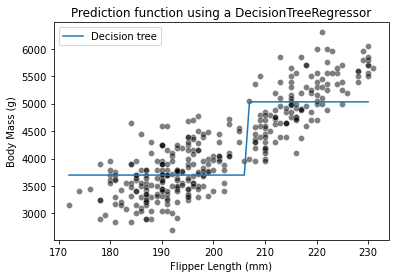

In [24]:
# plot data
sns.scatterplot(data=penguins, x=feature_name, y=target_name,
                color="black", alpha=0.5)
# plot predictions
plt.plot(data_test, target_predicted, label="Decision tree")
# add labels
plt.legend()
_ = plt.title("Prediction function using a DecisionTreeRegressor")

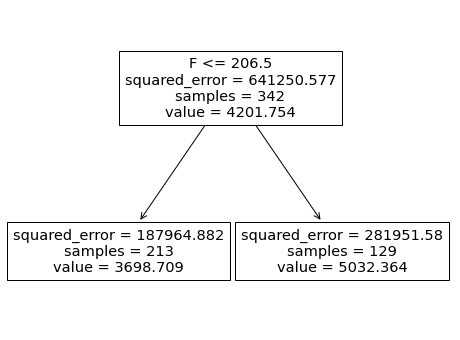

In [25]:
# examine tree structure
_, ax = plt.subplots(figsize=(8, 6))
_ = plot_tree(tree, feature_names=feature_name, ax=ax)

The threshold for our feature (flipper length) is 206.5 mm. The predicted values on each side of the split are two constants: 3683.50 g and 5023.62 g. __These values corresponds to the mean values of the training samples in each partition.__

In [26]:
# now create a model with a depth of 3
tree = DecisionTreeRegressor(max_depth=3)
# fit the model and make predictions
tree.fit(data_train, target_train)
target_predicted = tree.predict(data_test)

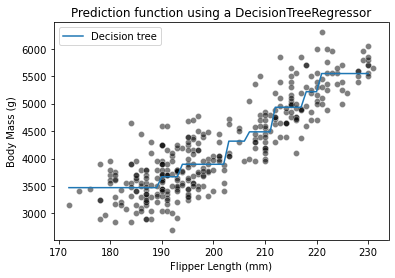

In [27]:
# plot data
sns.scatterplot(data=penguins, x=feature_name, y=target_name,
                color="black", alpha=0.5)
# plot predictions
plt.plot(data_test, target_predicted, label="Decision tree")
# add labels
plt.legend()
_ = plt.title("Prediction function using a DecisionTreeRegressor")

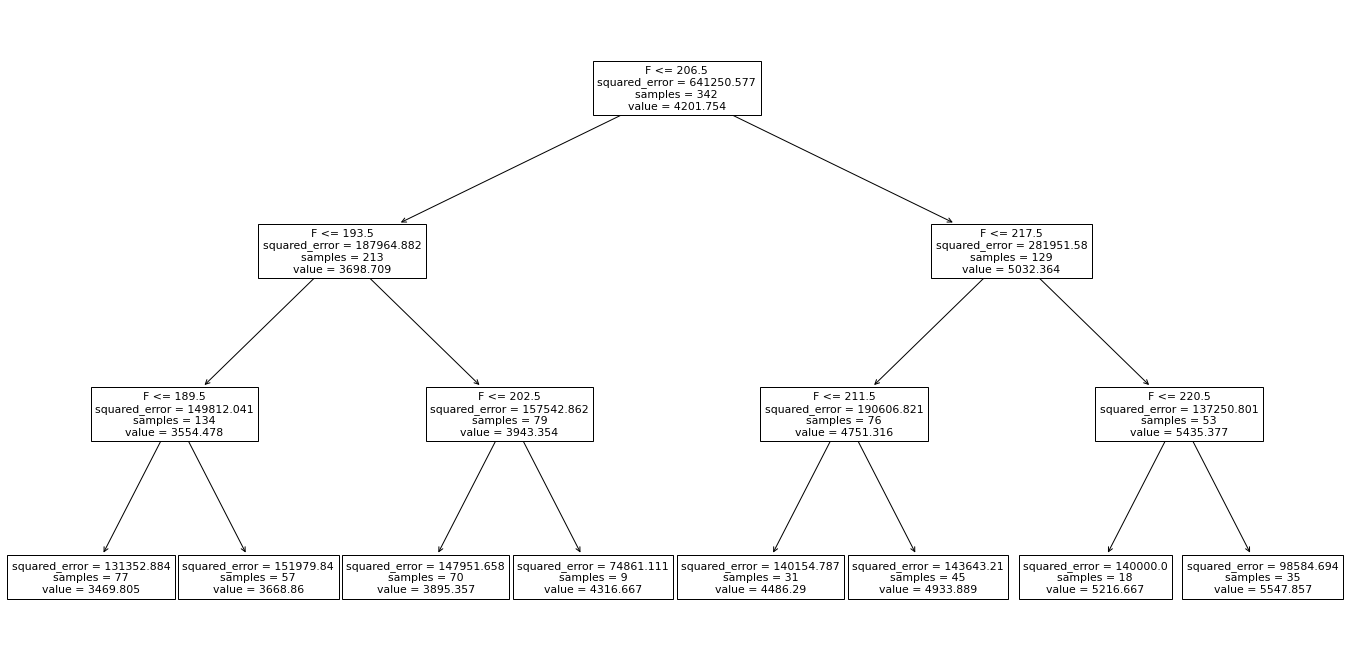

In [28]:
# examine tree structure
_, ax = plt.subplots(figsize=(24, 12))
_ = plot_tree(tree, feature_names=feature_name, ax=ax)

### Comparison to Linear Regression

In [29]:
from sklearn.linear_model import LinearRegression
# build linear model
linear_regression = LinearRegression()
# fit linear model
linear_regression.fit(data_train, target_train)

LinearRegression()

In [30]:
# create NEW synthetic dataset with a broader range of values than the previous dataset
offset = 30
data_test = pd.DataFrame(np.arange(data_train[feature_name].min() - offset,
                                   data_train[feature_name].max() + offset),
                         columns=[feature_name])

In [31]:
# generate new predictions on larger 'test' dataset for both models
target_predicted_linear_regression = linear_regression.predict(data_test)
target_predicted_tree = tree.predict(data_test)

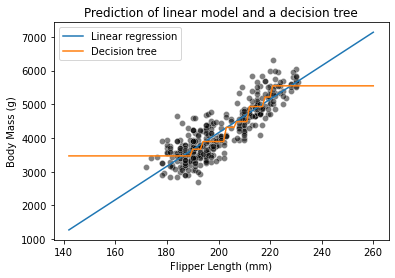

In [32]:
# plot actual data
sns.scatterplot(data=penguins, x=feature_name, y=target_name,
                color="black", alpha=0.5)
# plot Linear Regression predictions
plt.plot(data_test, target_predicted_linear_regression,
         label="Linear regression")
# plot Decision tree predictions
plt.plot(data_test, target_predicted_tree, label="Decision tree")
# add labels
plt.legend()
_ = plt.title("Prediction of linear model and a decision tree")

The linear model will __extrapolate__ using the fitted model for flipper lengths < 175 mm and > 235 mm. In fact, we are using the model parametrization to make this predictions.

As mentioned, decision trees are non-parametric models and we observe that they __cannot extrapolate__. For flipper lengths __below the minimum, the mass of the penguin in the training data with the shortest flipper length will always be predicted__. Similarly, for flipper lengths above the maximum, the mass of the penguin in the training data with the longest flipper will always be predicted.

## Hyperparameters

We will now examine the effect of key hyperparameters on tree models.

In [33]:
# classifcation data
data_clf_columns = ["Culmen Length (mm)", "Culmen Depth (mm)"]
target_clf_column = "Species"
data_clf = pd.read_csv("datasets/penguins_classification.csv")

In [34]:
# regression data
data_reg_columns = ["Flipper Length (mm)"]
target_reg_column = "Body Mass (g)"
data_reg = pd.read_csv("datasets/penguins_regression.csv")

In [35]:
# helper functions: These will fit the model and make predictions, then plot the data and the predictions at the same time
def plot_classification(model, X, y, ax=None):
    from sklearn.preprocessing import LabelEncoder
    model.fit(X, y)

    range_features = {
        feature_name: (X[feature_name].min() - 1, X[feature_name].max() + 1)
        for feature_name in X.columns
    }
    feature_names = list(range_features.keys())
    # create a grid to evaluate all possible samples
    plot_step = 0.02
    xx, yy = np.meshgrid(
        np.arange(*range_features[feature_names[0]], plot_step),
        np.arange(*range_features[feature_names[1]], plot_step),
    )

    # compute the associated prediction
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = LabelEncoder().fit_transform(Z)
    Z = Z.reshape(xx.shape)

    # make the plot of the boundary and the data samples
    if ax is None:
        _, ax = plt.subplots()
    ax.contourf(xx, yy, Z, alpha=0.4, cmap="RdBu")
    if y.nunique() == 3:
        palette = ["tab:red", "tab:blue", "black"]
    else:
        palette = ["tab:red", "tab:blue"]
    sns.scatterplot(
        x=data_clf_columns[0], y=data_clf_columns[1], hue=target_clf_column,
        data=data_clf, ax=ax, palette=palette)

    return ax

In [36]:
def plot_regression(model, X, y, ax=None):
    model.fit(X, y)

    X_test = pd.DataFrame(
        np.arange(X.iloc[:, 0].min(), X.iloc[:, 0].max()),
        columns=X.columns,
    )
    y_pred = model.predict(X_test)

    if ax is None:
        _, ax = plt.subplots()
    sns.scatterplot(x=X.iloc[:, 0], y=y, color="black", alpha=0.5, ax=ax)
    ax.plot(X_test, y_pred, linewidth=4)

    return ax

### (i) Max Depth

In [37]:
# start both models with a depth of 2
max_depth = 2
tree_clf = DecisionTreeClassifier(max_depth=max_depth)
tree_reg = DecisionTreeRegressor(max_depth=max_depth)

C:\Users\GGN04\Anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


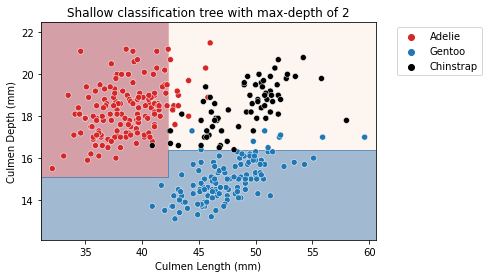

In [38]:
plot_classification(tree_clf, data_clf[data_clf_columns],
                    data_clf[target_clf_column])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
_ = plt.title(f"Shallow classification tree with max-depth of {max_depth}")

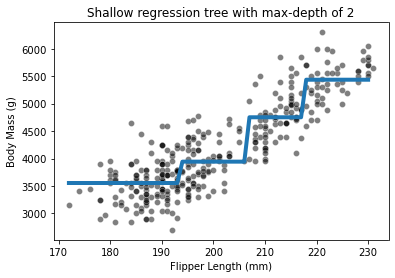

In [39]:
plot_regression(tree_reg, data_reg[data_reg_columns],
                data_reg[target_reg_column])
_ = plt.title(f"Shallow regression tree with max-depth of {max_depth}")

In [40]:
# increase max_depth to 30
max_depth = 30
tree_clf = DecisionTreeClassifier(max_depth=max_depth)
tree_reg = DecisionTreeRegressor(max_depth=max_depth)

C:\Users\GGN04\Anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


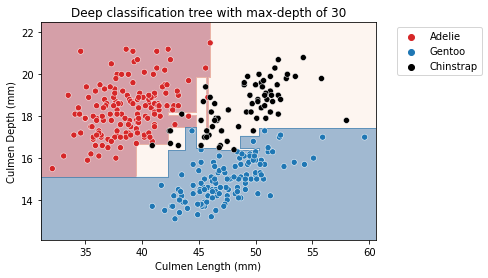

In [41]:
plot_classification(tree_clf, data_clf[data_clf_columns],
                    data_clf[target_clf_column])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
_ = plt.title(f"Deep classification tree with max-depth of {max_depth}")

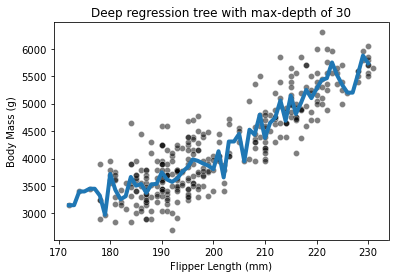

In [42]:
plot_regression(tree_reg, data_reg[data_reg_columns],
                data_reg[target_reg_column])
_ = plt.title(f"Deep regression tree with max-depth of {max_depth}")

Increasing the parameter `max_depth` too far leads to overfitting, but having it too low leads to underfitting.

In [43]:
# search for best paramter value
from sklearn.model_selection import GridSearchCV

# provide array of values to select from
param_grid = {"max_depth": np.arange(2, 10, 1)}
# create two models
tree_clf = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid)
tree_reg = GridSearchCV(DecisionTreeRegressor(), param_grid=param_grid)

C:\Users\GGN04\Anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


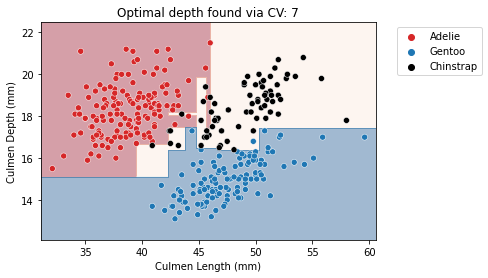

In [44]:
plot_classification(tree_clf, data_clf[data_clf_columns],
                    data_clf[target_clf_column])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
_ = plt.title(f"Optimal depth found via CV: "
              f"{tree_clf.best_params_['max_depth']}")

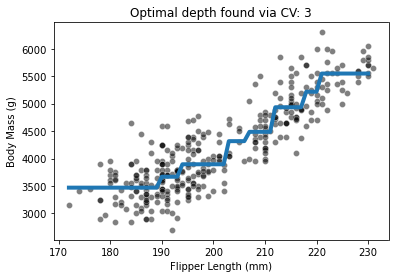

In [45]:
plot_regression(tree_reg, data_reg[data_reg_columns],
                data_reg[target_reg_column])
_ = plt.title(f"Optimal depth found via CV: "
              f"{tree_reg.best_params_['max_depth']}")

The max_depth hyperparameter controls the overall complexity of the tree. This parameter is adequate under the __assumption that a tree is built is symmetric__. However, there is no guarantee that a tree will be symmetric. Indeed, __optimal generalization performance could be reached by growing some of the branches deeper than some others__.

In [46]:
# create synthetic dataset
from sklearn.datasets import make_blobs

data_clf_columns = ["Feature #0", "Feature #1"]
target_clf_column = "Class"

# Blobs that will be interlaced
X_1, y_1 = make_blobs(
    n_samples=300, centers=[[0, 0], [-1, -1]], random_state=0)
# Blobs that will be easily separated
X_2, y_2 = make_blobs(
    n_samples=300, centers=[[3, 6], [7, 0]], random_state=0)

# combine sets of co-ordinates
X = np.concatenate([X_1, X_2], axis=0)
y = np.concatenate([y_1, y_2])
data_clf = np.concatenate([X, y[:, np.newaxis]], axis=1)
# combine in dataframe
data_clf = pd.DataFrame(
    data_clf, columns=data_clf_columns + [target_clf_column])
# set type to int
data_clf[target_clf_column] = data_clf[target_clf_column].astype(np.int32)

C:\Users\GGN04\Anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


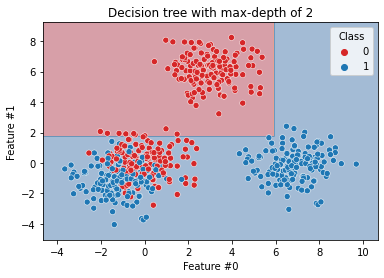

In [47]:
max_depth = 2
tree_clf = DecisionTreeClassifier(max_depth=max_depth)
plot_classification(tree_clf, data_clf[data_clf_columns],
                    data_clf[target_clf_column])
_ = plt.title(f"Decision tree with max-depth of {max_depth}")

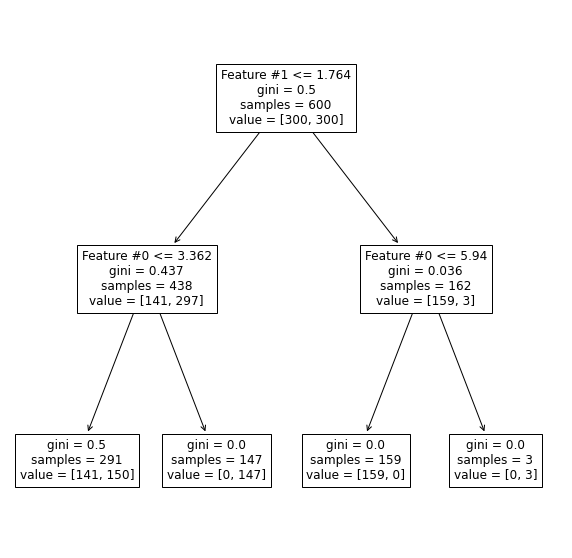

In [48]:
_, ax = plt.subplots(figsize=(10, 10))
_ = plot_tree(tree_clf, ax=ax, feature_names=data_clf_columns)

C:\Users\GGN04\Anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


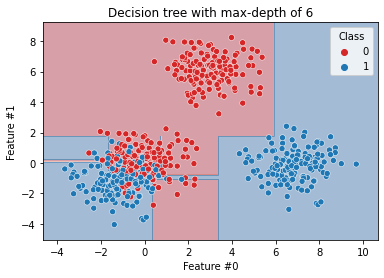

In [49]:
max_depth = 6
tree_clf = DecisionTreeClassifier(max_depth=max_depth)
plot_classification(tree_clf, data_clf[data_clf_columns],
                    data_clf[target_clf_column])
_ = plt.title(f"Decision tree with max-depth of {max_depth}")

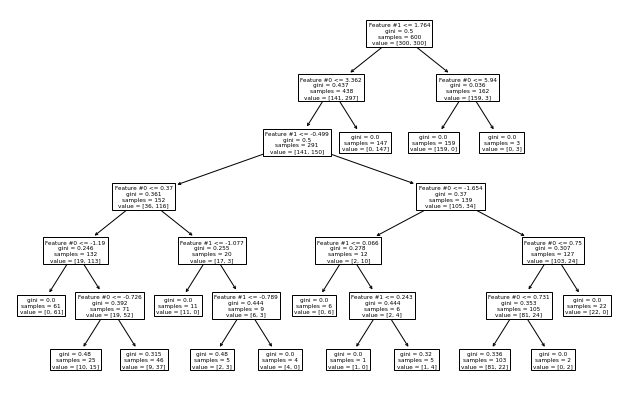

In [50]:
_, ax = plt.subplots(figsize=(11, 7))
_ = plot_tree(tree_clf, ax=ax, feature_names=data_clf_columns)

As expected, 
- the left branch of the tree continue to grow while 
- no further splits were done on the right branch. 

Fixing the max_depth parameter would cut the tree horizontally at a specific level, whether or not it would be more beneficial that a branch continue growing.

The hyperparameters `min_samples_leaf`, `min_samples_split`, `max_leaf_nodes`, or `min_impurity_decrease` allows growing asymmetric trees and apply a constraint at the leaves or nodes level.

### (ii) Min Samples Leaf

C:\Users\GGN04\Anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


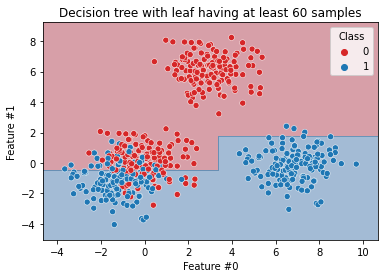

In [51]:
min_samples_leaf = 60
tree_clf = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
plot_classification(tree_clf, data_clf[data_clf_columns],
                    data_clf[target_clf_column])
_ = plt.title(
    f"Decision tree with leaf having at least {min_samples_leaf} samples")

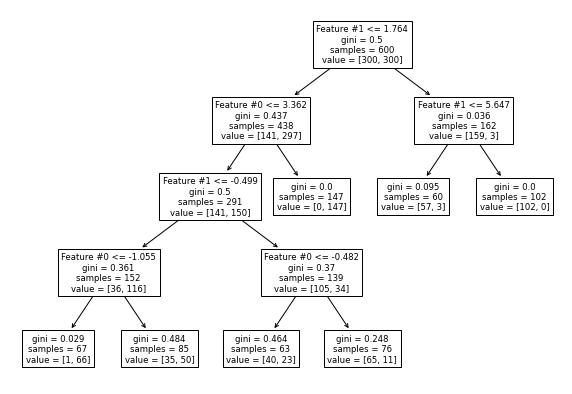

In [52]:
_, ax = plt.subplots(figsize=(10, 7))
_ = plot_tree(tree_clf, ax=ax, feature_names=data_clf_columns)

We see that every leaf has 60 or more samples, and no split nodes occur after that level is reached.

## Summary

Tree models are:
- suited for both regression and classification problems;

- non-parametric models;

- not able to extrapolate;

- sensitive to hyperparameter tuning.